# Electricity Load Forecasting with Apache Spark

This project uses Apache Spark and machine learning to forecast electricity consumption in Germany using historical hourly load data. The goal is to predict future load based on past patterns using time-series features.


LOAD THE DATASET

In [0]:
#Load the dataset into a Spark DataFrame
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .csv("/FileStore/tables/time_series_60min_singleindex.csv")

#Check the schema of the dataset
df.printSchema()

#Show the first few rows
df.show(5)


root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [0]:
#Show all column names in the dataset
columns = df.columns
print("Total columns:", len(columns))
columns[:20]  #show first 20 columns


Total columns: 300
Out[2]: ['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity']

In [0]:
#Select only the timestamp and Germany's actual load data
df_de = df.select("utc_timestamp", "DE_load_actual_entsoe_transparency")

#Rename columns for clarity
df_de = df_de.withColumnRenamed("utc_timestamp", "timestamp") \
             .withColumnRenamed("DE_load_actual_entsoe_transparency", "load_MW")

#Drop rows with null values
df_de = df_de.dropna()

#Show first few cleaned rows
df_de.show(5)


+-------------------+-------+
|          timestamp|load_MW|
+-------------------+-------+
|2015-01-01 00:00:00|41151.0|
|2015-01-01 01:00:00|40135.0|
|2015-01-01 02:00:00|39106.0|
|2015-01-01 03:00:00|38765.0|
|2015-01-01 04:00:00|38941.0|
+-------------------+-------+
only showing top 5 rows



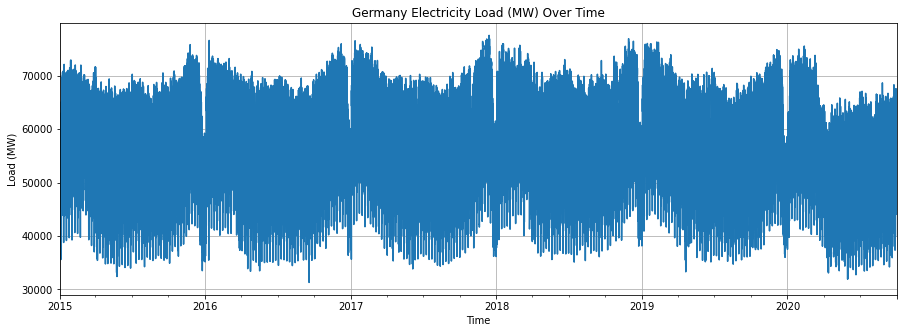

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

#Convert to pandas DataFrame
df_pd = df_de.toPandas()

#Convert timestamp column to datetime type
df_pd['timestamp'] = pd.to_datetime(df_pd['timestamp'])

#Set timestamp as index
df_pd.set_index('timestamp', inplace=True)

#Plot the load over time
plt.figure(figsize=(15, 5))
df_pd['load_MW'].plot(title="Germany Electricity Load (MW) Over Time")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


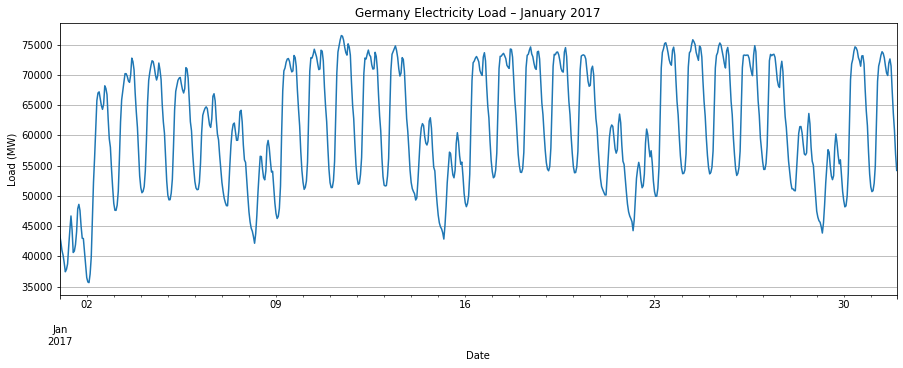

In [0]:
#plot 1 month of data (Jan 2017)
df_pd_zoom = df_pd['2017-01-01':'2017-01-31']

plt.figure(figsize=(15, 5))
df_pd_zoom['load_MW'].plot(title="Germany Electricity Load – January 2017")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag

#Create a window ordered by time
window_spec = Window.orderBy("timestamp")

#Add lag features: 1 hour, 24 hours, and 168 hours (1 week)
df_lagged = df_de \
    .withColumn("lag_1h", lag("load_MW", 1).over(window_spec)) \
    .withColumn("lag_24h", lag("load_MW", 24).over(window_spec)) \
    .withColumn("lag_168h", lag("load_MW", 168).over(window_spec)) \
    .dropna()

#Preview the result
df_lagged.show(5)


+-------------------+-------+-------+-------+--------+
|          timestamp|load_MW| lag_1h|lag_24h|lag_168h|
+-------------------+-------+-------+-------+--------+
|2015-01-08 00:00:00|48041.0|50460.0|45125.0| 41151.0|
|2015-01-08 01:00:00|47074.0|48041.0|44217.0| 40135.0|
|2015-01-08 02:00:00|47228.0|47074.0|44368.0| 39106.0|
|2015-01-08 03:00:00|48253.0|47228.0|45298.0| 38765.0|
|2015-01-08 04:00:00|51155.0|48253.0|48598.0| 38941.0|
+-------------------+-------+-------+-------+--------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

#Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["lag_1h", "lag_24h", "lag_168h"],
    outputCol="features"
)

#Transform the DataFrame
df_model = assembler.transform(df_lagged).select("features", "load_MW")

#Rename target column
df_model = df_model.withColumnRenamed("load_MW", "label")
df_model.show(5)


+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[50460.0,45125.0,...|48041.0|
|[48041.0,44217.0,...|47074.0|
|[47074.0,44368.0,...|47228.0|
|[47228.0,45298.0,...|48253.0|
|[48253.0,48598.0,...|51155.0|
+--------------------+-------+
only showing top 5 rows



In [0]:
#Split data into training and test sets
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)

#Initialize Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="label")

#Fit the model
lr_model = lr.fit(train_data)

#Predict on test data
predictions = lr_model.transform(test_data)

#Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

#Show a few predictions
predictions.select("features", "label", "prediction").show(5)


Root Mean Squared Error (RMSE): 2144.07
+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|[31598.0,39837.0,...|31307.0|  32833.7136156954|
|[32397.0,36878.0,...|31923.0|32878.790656242534|
|[32507.0,41306.0,...|34612.0| 33998.05835755499|
|[32669.0,32829.0,...|32040.0| 33402.98531453401|
|[32918.0,36406.0,...|32743.0|33050.128635026595|
+--------------------+-------+------------------+
only showing top 5 rows



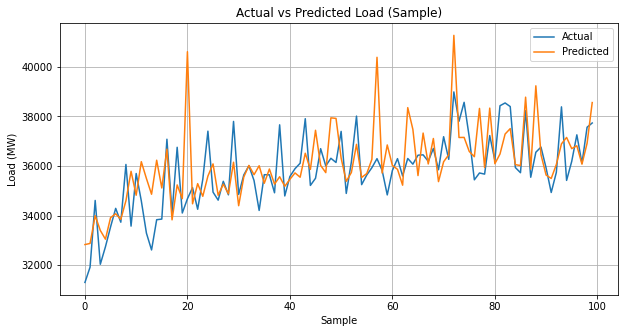

In [0]:
predictions_pd = predictions.select("label", "prediction").toPandas()

plt.figure(figsize=(10, 5))
plt.plot(predictions_pd['label'][:100], label='Actual')
plt.plot(predictions_pd['prediction'][:100], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Load (Sample)")
plt.xlabel("Sample")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


In [0]:
from pyspark.ml.regression import RandomForestRegressor

#Initialize Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)

#Train the model
rf_model = rf.fit(train_data)

#Predict on test data
rf_predictions = rf_model.transform(test_data)

#Evaluate RMSE
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse:.2f}")

#Show sample predictions
rf_predictions.select("label", "prediction").show(5)


Random Forest RMSE: 1547.61
+-------+------------------+
|  label|        prediction|
+-------+------------------+
|31307.0|36423.126335214896|
|31923.0|36801.669155865915|
|34612.0|36662.814987211204|
|32040.0|36801.669155865915|
|32743.0|36801.669155865915|
+-------+------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.regression import GBTRegressor

#Initialize Gradient-Boosted Tree model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5)

#Train the model
gbt_model = gbt.fit(train_data)

#Predict on test data
gbt_predictions = gbt_model.transform(test_data)

#Evaluate RMSE
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"GBT RMSE: {gbt_rmse:.2f}")

#Show sample predictions
gbt_predictions.select("label", "prediction").show(5)


GBT RMSE: 1535.80
+-------+-----------------+
|  label|       prediction|
+-------+-----------------+
|31307.0|35661.32196277871|
|31923.0|35976.57157462306|
|34612.0|36357.99466382803|
|32040.0|35976.57157462306|
|32743.0|35976.57157462306|
+-------+-----------------+
only showing top 5 rows

